# Cell size computation

Approaches for cell size computation

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import scanpy as sc
import scipy.sparse as sparse

from scipy.optimize import root, minimize, root_scalar, diagbroyden, least_squares, approx_fprime
import scipy.optimize as opt

In [2]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'
data_path = '/data/parameter_estimation/'

### Read IFN data

In [82]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.cell == 'CD14+ Monocytes')].copy()

### Implement pooled TMM

In [83]:
def trimmed_mean(a, b):
    
    ratio = a / b
    
#     return np.median(ratio)
    llim, ulim = np.quantile(ratio, [0.3, 0.7])
    
    return ratio[(ratio > llim) & (ratio < ulim)].mean()
    

In [84]:
means = adata.X.mean(axis=0).A1

In [85]:
# Gene selection
expr_matrix = adata.X[:, means > 0.2].copy()
library_count = expr_matrix.sum(axis=1).A1
library_count /= library_count.mean()

In [86]:
# library count normalization
expr_matrix = sparse.diags(1/library_count)@expr_matrix

# Mean pseudocell
mean_cell = expr_matrix.mean(axis=0).A1

In [87]:
%%time

pool_factors_list = []
toeplitz_list = []
n_cells = expr_matrix.shape[0]

for window_size in range(100, 200, 20):
    
    pool_factors = np.zeros(n_cells)

    # ith pool includes cell indices i to i+window_size-1
    pool_sum = expr_matrix[:window_size, :].sum(axis=0).A1
    pool_factors[0] = trimmed_mean(pool_sum, mean_cell)
    for pool in range(n_cells-1):

        i = pool # index to subtract
        j = (pool + window_size) % n_cells # index to add 

        pool_sum[expr_matrix.indices[expr_matrix.indptr[i]:expr_matrix.indptr[i+1]]] -= \
            expr_matrix.data[expr_matrix.indptr[i]:expr_matrix.indptr[i+1]]
        pool_sum[expr_matrix.indices[expr_matrix.indptr[j]:expr_matrix.indptr[j+1]]] += \
            expr_matrix.data[expr_matrix.indptr[j]:expr_matrix.indptr[j+1]]

        pool_factors[pool + 1] = trimmed_mean(pool_sum, mean_cell)
    
    toeplitz = \
        sparse.diags(diagonals=np.ones(window_size), offsets=np.arange(window_size), shape=(n_cells, n_cells)) + \
        sparse.diags(diagonals=np.ones(window_size), offsets=np.arange(window_size)-n_cells, shape=(n_cells, n_cells))
    
    pool_factors_list.append(pool_factors)
    toeplitz_list.append(toeplitz)


CPU times: user 4.03 s, sys: 418 µs, total: 4.03 s
Wall time: 4.03 s


In [88]:
pool_factors = np.concatenate(pool_factors_list)
del pool_factors_list
toeplitz = sparse.vstack(toeplitz_list)
del toeplitz_list

In [98]:
toeplitz.shape

(26705, 5341)

In [89]:
%%time
res = sparse.linalg.lsqr(toeplitz, pool_factors)

CPU times: user 4min 48s, sys: 6min 24s, total: 11min 13s
Wall time: 1min 24s


In [90]:
size_factor = res[0]*library_count

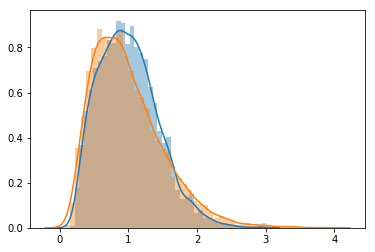

In [99]:
sns.distplot(library_count)
sns.distplot(size_factor)


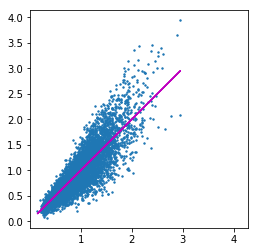

In [96]:
plt.scatter(library_count, size_factor, s=2);
plt.plot(library_count, library_count, c='m')
plt.axis('square');

### compute using least variable genes

In [100]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.1-py3.7.egg')
import memento

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [101]:
memento.create_groups(adata, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

In [103]:
adata.uns['memento'].keys()

dict_keys(['label_columns', 'label_delimiter', 'groups', 'q', 'estimator_type', 'group_cells', 'least_variable_genes', 'all_size_factor', 'all_total_size_factor', 'all_approx_size_factor', 'approx_size_factor', 'size_factor', '1d_moments', 'gene_filter', 'overall_gene_filter', 'gene_list', 'mv_regressor'])

In [105]:
size_factor

array([1.17751307, 0.86844223, 1.45197669, ..., 2.3591099 , 0.42157514,
       0.59936391])

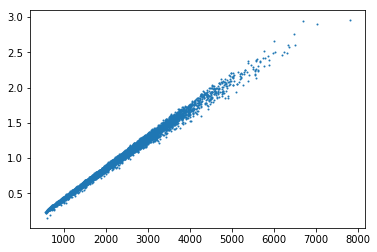

In [111]:
stats.pearsonr(adata.uns['memento']['all_total_size_factor'], library_count)
plt.scatter(adata.uns['memento']['all_total_size_factor'], library_count, s=1)

In [ ]:
stats.pearsonr(adata.uns['memento']['all_size_factor'], size_factor)

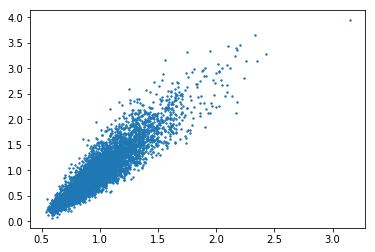

In [107]:
plt.scatter(adata.uns['memento']['all_size_factor'], size_factor, s=2)

In [104]:
adata.uns['memento']['all_size_factor']

array([1.2045144 , 0.95879346, 1.344238  , ..., 1.6381396 , 0.71307254,
       0.838342  ], dtype=float32)